# Advanced Sound Synthesis and Analysis Notebook

This notebook processes an input audio file (`input.m4a`) that contains two (or more) separate sound events. Instead of synthesizing two simultaneous tones, it:

1. Detects onsets to segment the audio into separate events.
2. For each event, extracts its amplitude envelope.
3. Performs a frequency analysis to determine the fundamental frequency and up to three additional harmonics.
4. Synthesizes each event using additive synthesis (summing sine waves for the fundamental and its harmonics), with the envelope applied.
5. Places each synthesized event back in time so that their timing and durations match the original.
6. Optionally applies a convolution-based reverb to simulate room acoustics.

Adjust parameters (such as onset detection, envelope smoothing, or harmonic estimation) as needed to better match the original sound.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import find_peaks, fftconvolve
from scipy.interpolate import interp1d
import sounddevice as sd
import soundfile as sf

print('Libraries imported successfully.')

Libraries imported successfully.


## 1. Load and Visualize the Audio File

We load the provided `input.m4a` file and display its waveform and spectrogram. (Make sure you have the appropriate codecs, e.g. ffmpeg, installed.)

Loaded audio file: input.m4a
Sample Rate: 48000 Hz
Duration: 1.00 seconds


/var/folders/40/z7rg0xk57ygcsp6h9_ww9k480000gn/T/ipykernel_2569/2661872247.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
/Users/bytter/Development/tone-rebuilder/venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


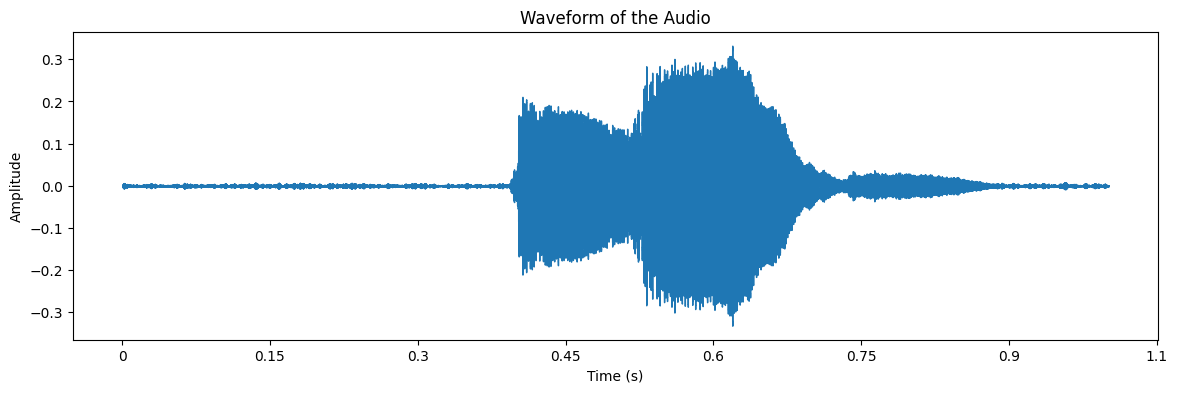

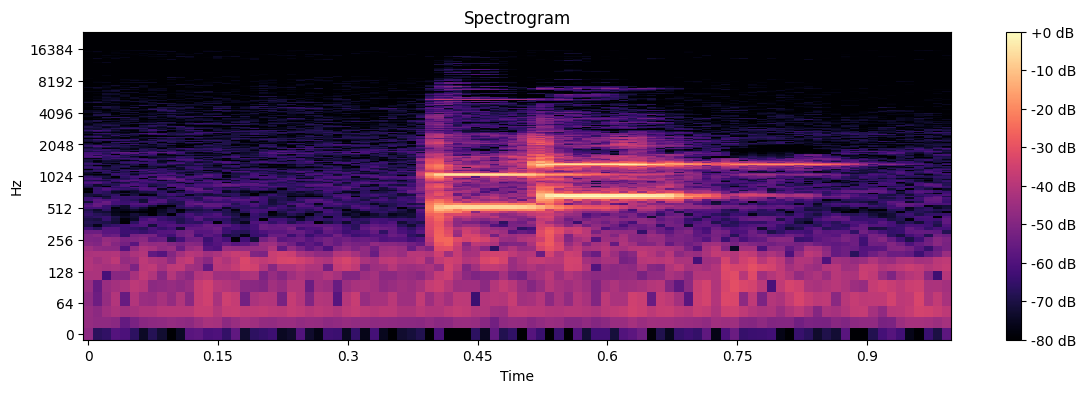

In [24]:
# Load the audio file
audio_path = 'input.m4a'  
y, sr = librosa.load(audio_path, sr=None)  
duration = len(y) / sr
print(f'Loaded audio file: {audio_path}\nSample Rate: {sr} Hz\nDuration: {duration:.2f} seconds')

# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Compute and display spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(14, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

## 2. Detect Onsets (Event Segmentation)

We use Librosa’s onset detection to find the starting sample of each separate sound event. These onsets will be used to segment the audio.

Detected onsets (in seconds): [0.032      0.40533333 0.53333333]


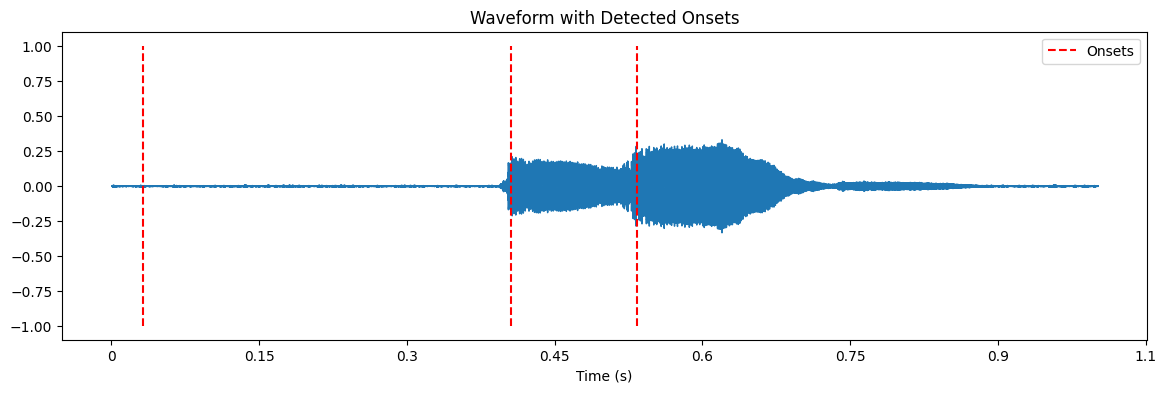

In [64]:
# Detect onsets in the audio (in sample indices)
onset_samples = librosa.onset.onset_detect(y=y, sr=sr, units='samples')
onset_times = onset_samples / sr
print('Detected onsets (in seconds):', onset_times)

# Plot the onsets on the waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.vlines(onset_times, -1, 1, color='r', linestyle='--', label='Onsets')
plt.title('Waveform with Detected Onsets')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

## 3. Segment and Synthesize Each Event

For each detected event, we:

- Extract the event's segment from the original audio.
- Compute a smoothed envelope (using a simple moving average on the absolute value).
- Analyze the segment via FFT to estimate the fundamental frequency and additional harmonics.
- Synthesize the event via additive synthesis (summing sine waves at the fundamental and up to three harmonics, with amplitudes estimated from the FFT and modulated by the event envelope).

Finally, we place each synthesized event in its proper time slot to create a full synthesized signal.

Processing 3 events...
Event 1: fundamental frequency = 21.43 Hz, duration = 0.37 s
Harmonic 1: frequency = 21.43 Hz, amplitude = 1.71
Harmonic 2: frequency = 42.86 Hz, amplitude = 2.11
Harmonic 3: frequency = 64.29 Hz, amplitude = 1.08
Harmonic 4: frequency = 85.71 Hz, amplitude = 6.22
Event 2: fundamental frequency = 523.44 Hz, duration = 0.13 s
Harmonic 1: frequency = 523.44 Hz, amplitude = 172.64
Harmonic 2: frequency = 1046.88 Hz, amplitude = 91.29
Harmonic 3: frequency = 1570.31 Hz, amplitude = 5.11
Harmonic 4: frequency = 2093.75 Hz, amplitude = 1.77
Event 3: fundamental frequency = 664.53 Hz, duration = 0.47 s
Harmonic 1: frequency = 664.53 Hz, amplitude = 510.14
Harmonic 2: frequency = 1329.06 Hz, amplitude = 363.96
Harmonic 3: frequency = 1993.59 Hz, amplitude = 4.14
Harmonic 4: frequency = 2658.12 Hz, amplitude = 0.41


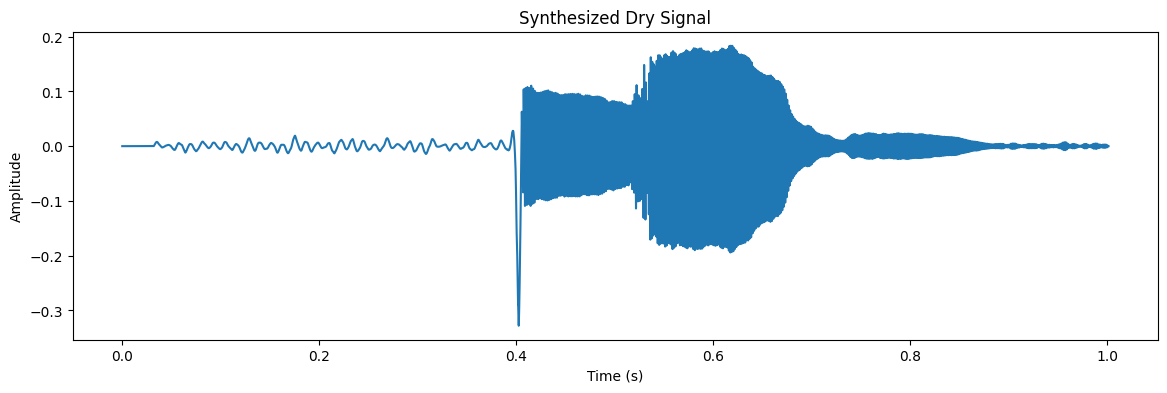

In [65]:
# Initialize an empty array for the final synthesized signal
synthesized = np.zeros_like(y)

# Loop over each event using the detected onsets
# Discard the first event as it's related to the initial silence
# onset_samples = onset_samples[1:]

num_events = len(onset_samples)
print(f'Processing {num_events} events...')

# Discard the first event as it's related to the initial silence
for i in range(num_events):
    start = onset_samples[i]
    # For the last event, use the end of the signal
    end = onset_samples[i+1] if i < num_events - 1 else len(y)
    event_signal = y[start:end]
    event_duration = (end - start) / sr

    # Compute a simple envelope via moving average
    window_size = 256  # adjust for smoothing
    envelope_event = np.convolve(np.abs(event_signal), np.ones(window_size)/window_size, mode='same')

    # FFT analysis for this event
    N_event = len(event_signal)
    Y_event = np.abs(np.fft.rfft(event_signal))
    freqs_event = np.fft.rfftfreq(N_event, d=1/sr)

    # Find peaks in the event spectrum (using a threshold relative to the event's max)
    peaks_event, _ = find_peaks(Y_event, height=np.max(Y_event)*0.1, distance=10)

    if len(peaks_event) == 0:
        print(f'No significant peaks found for event {i+1}; skipping.')
        continue

    # Assume the lowest-frequency peak is the fundamental
    fundamental = freqs_event[np.sort(peaks_event)[0]]
    print(f'Event {i+1}: fundamental frequency = {fundamental:.2f} Hz, duration = {event_duration:.2f} s')

    # Estimate harmonics (up to 4 harmonics: fundamental, 2nd, 3rd, 4th)
    harmonics = []
    for n in range(1, 5):
        target_freq = n * fundamental
        idx = np.argmin(np.abs(freqs_event - target_freq))
        amplitude = Y_event[idx]
        harmonics.append((target_freq, amplitude))
        # Print the harmonic frequency and amplitude
        print(f'Harmonic {n}: frequency = {target_freq:.2f} Hz, amplitude = {amplitude:.2f}')
        
    # Normalize harmonic amplitudes relative to the fundamental
    amp_fund = harmonics[0][1]
    norm_factors = [amp / amp_fund for (_, amp) in harmonics]

    # Create a time vector for the event
    t_event = np.linspace(0, event_duration, N_event, endpoint=False)

    # Synthesize the event using additive synthesis
    synth_event = np.zeros(N_event)
    for n, (freq, _) in enumerate(harmonics):
        synth_event += norm_factors[n] * envelope_event * np.sin(2 * np.pi * freq * t_event)

    # Insert the synthesized event into the final synthesized signal
    synthesized[start:end] += synth_event

# Plot a short segment of the synthesized (dry) signal
t_full = np.linspace(0, duration, len(synthesized), endpoint=False)
plt.figure(figsize=(14, 4))
plt.plot(t_full, synthesized)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthesized Dry Signal')
plt.show()

## 4. Apply a Convolution-Based Reverb

We simulate a reverb effect by convolving the dry synthesized signal with a synthetic impulse response. Here an exponential decay impulse response is used.

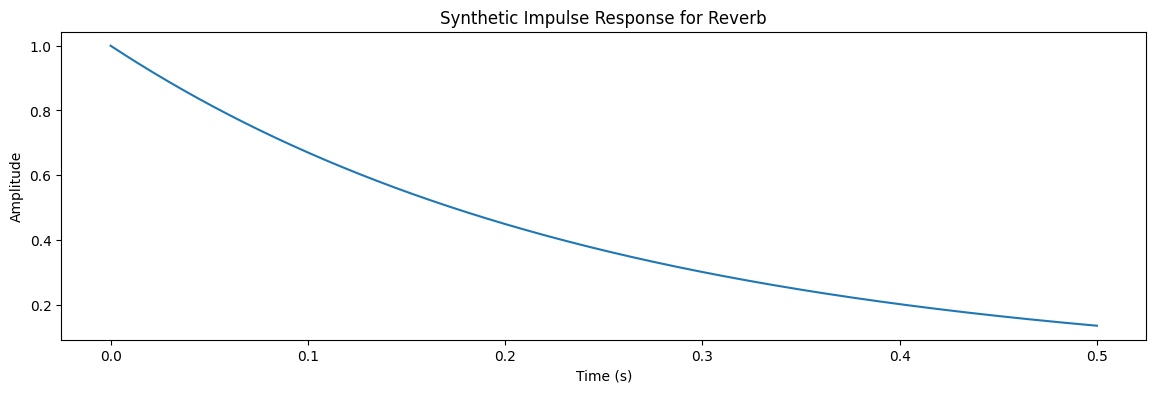

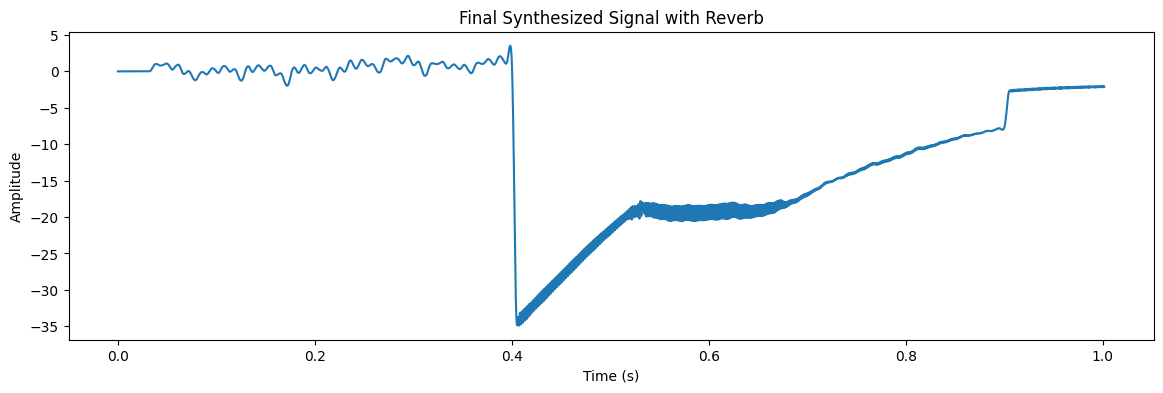

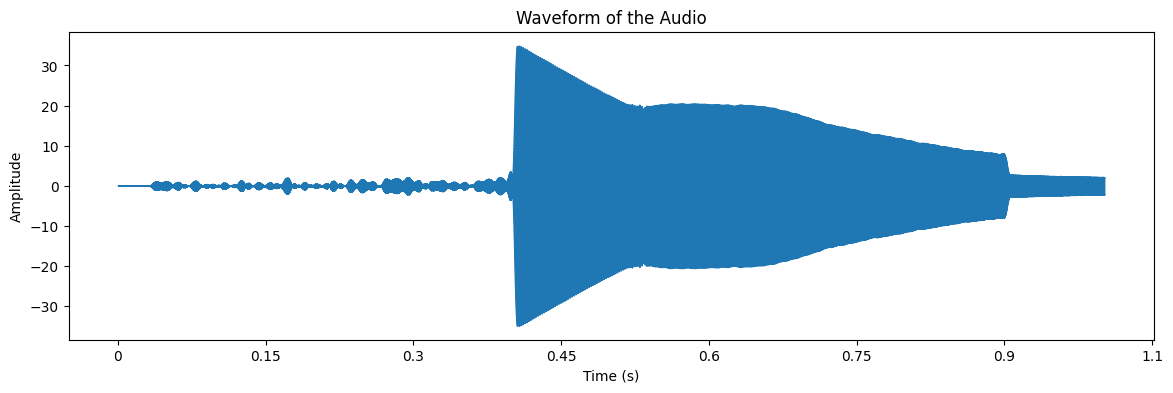

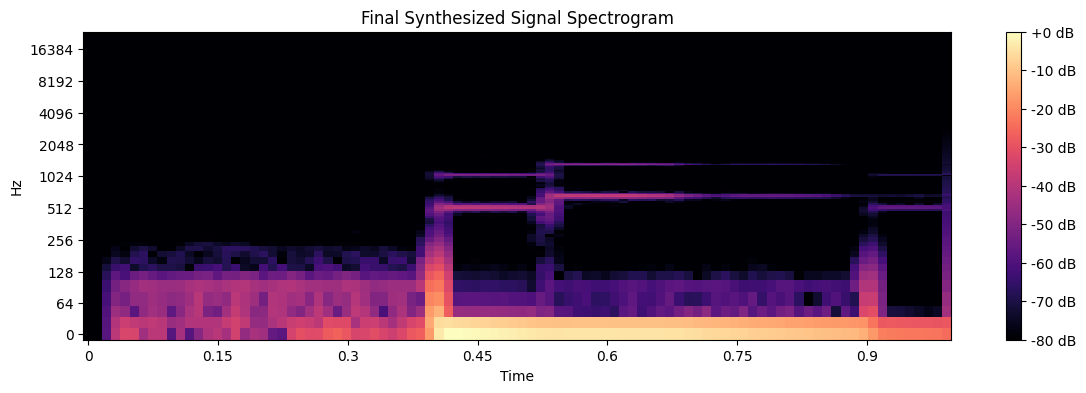

In [68]:
def create_impulse_response(sr, ir_duration=0.5, decay=3.0):
    t_ir = np.linspace(0, ir_duration, int(sr * ir_duration), endpoint=False)
    ir = np.exp(-decay * t_ir)  # exponential decay
    ir /= np.max(ir)            # normalize
    return ir

# Generate the impulse response
ir = create_impulse_response(sr, ir_duration=0.5, decay=4.0)

# Plot the impulse response
plt.figure(figsize=(14, 4))
plt.plot(np.linspace(0, 0.5, len(ir)), ir)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthetic Impulse Response for Reverb')
plt.show()

# Apply convolution-based reverb (using FFT-based convolution)
wet_signal = fftconvolve(synthesized, ir, mode='full')
wet_signal = wet_signal[:len(synthesized)]  # Trim to original length

# Mix dry and wet signals
final_signal = 0.7 * wet_signal + 0.3 * synthesized

plt.figure(figsize=(14, 4))
plt.plot(t_full, final_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Final Synthesized Signal with Reverb')
plt.show()

# Plot new signal
plt.figure(figsize=(14, 4))
librosa.display.waveshow(final_signal, sr=sr)
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Compute and display spectrogram of the new signal
D = librosa.amplitude_to_db(np.abs(librosa.stft(final_signal)), ref=np.max)
plt.figure(figsize=(14, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Final Synthesized Signal Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

## 5. Playback and Save the Final Synthesized Sound

We use `sounddevice` to play the final signal and `soundfile` to save it as a WAV file.

In [62]:
# Normalize to prevent clipping
max_val = np.max(np.abs(final_signal))
if max_val > 0:
    final_signal = final_signal / max_val

print('Playing the final synthesized sound...')
sd.play(final_signal, sr)
sd.wait()

# Save to file
output_file = 'advanced_synthesized_sound.wav'
sf.write(output_file, final_signal, sr)
print(f'Final synthesized sound saved to {output_file}')

Playing the final synthesized sound...
Final synthesized sound saved to advanced_synthesized_sound.wav


## End of Notebook

This notebook demonstrated an event-based synthesis approach to better capture the timing, envelope duration, and harmonic structure of the original sound. Fine-tune the parameters (such as window sizes, threshold levels, or harmonic extraction methods) as needed to approach the target sound more closely.